Click [here]() to access the associated Medium article.

# Setup

In [30]:
!pip install -q scipy pandas matplotlib scikit-learn tensorflow keras

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Data

In [2]:
from urllib.request import urlretrieve

# Download the dataset to the current directory (149 MB)
# Source: https://www.openml.org/search?type=data&id=43627
url = "https://www.openml.org/data/download/22102452"
file_name = "credit_card.arff"
urlretrieve(url, file_name)

('credit_card.arff', <http.client.HTTPMessage at 0x10674d490>)

In [7]:
from scipy.io import arff
import pandas as pd

# Convert the dataset in arff format into a pandas dataframe
data_arff = arff.loadarff("credit_card.arff")
data = pd.DataFrame(data_arff[0])

data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0


In [4]:
from pprint import pprint

# Display basic information about the dataset
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

print("\nColumn names:")
pprint(data.columns.values.tolist(), compact=True, width=60)

print("\nTarget distribution:")
print(data["Class"].value_counts())

print("\nSummary statistics:")
print(data.describe().applymap(lambda x: f"{x: 0.2f}"))

Number of rows: 284807
Number of columns: 31

Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Target distribution:
Class
0.0    284315
1.0       492
Name: count, dtype: int64

Summary statistics:
             Time          V1          V2          V3          V4          V5  \
count   284807.00   284807.00   284807.00   284807.00   284807.00   284807.00   
mean     94813.86        0.00        0.00       -0.00        0.00        0.00   
std      47488.15        1.96        1.65        1.52        1.42        1.38   
min          0.00      -56.41      -72.72      -48.33       -5.68     -113.74   
25%      54201.50       -0.92       -0.60       -0.89       -0.85       -0.69   
50%      84692.00        0.02        0.07        0.18       -0.02       -0.05   
75%     139320.50        1.32        0.80        1.0

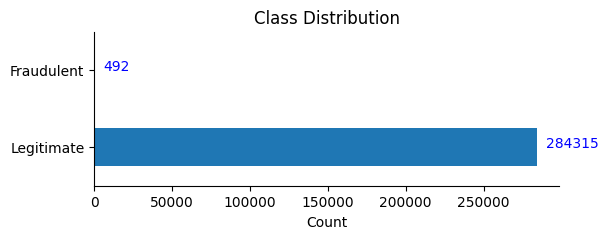

In [5]:
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
class_counts = data["Class"].value_counts()

ax = class_counts.plot(
    kind="barh",
    figsize=(6, 2),
    title="Class Distribution",
    xlabel="Count",
    ylabel="",
)
ax.set_yticklabels(["Legitimate", "Fraudulent"])
ax.spines[["right", "top"]].set_visible(False)

# Print the count of each class
for index, value in enumerate(class_counts):
    plt.text(
        value + int(class_counts[0] / 50),
        index,
        str(value),
        color="blue",
    )

# Preprocessing

## Handling Missing Values

In [6]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Display columns with missing values
print(f"Columns with missing values:\n{missing_values[missing_values > 0]}")

Columns with missing values:
Series([], dtype: int64)


## Train-Test Splitting

In [8]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop("Class", axis=1)
y = data["Class"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Class Weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the unique classes
unique_classes = np.unique(y_train)

# Calculate class weights
class_weights_array = compute_class_weight(
    class_weight="balanced", classes=unique_classes, y=y_train
)

# Convert class weights to a dictionary for model training
class_weights = dict(zip(unique_classes, class_weights_array))
print(f"Class weights: {class_weights}")

Class weights: {0.0: 0.5008661206149896, 1.0: 289.14340101522845}


## Standard Scaling

In [26]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Building a Binary Classification Model

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

dropout_rate = 0.25

# Define the model
model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(X_train.shape[-1],)),
        Dense(256, activation="relu"),
        Dropout(dropout_rate),
        Dense(256, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ]
)

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139777 (546.00 KB)
Trainable params: 13977